In [81]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os
import random

# random seed
tf.random.set_seed(2)
random.seed(2)
np.random.seed(2)

## 데이터 불러오기 + Resize 하기

In [2]:
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    print(len(images), " images resized.")

    

image_dir_path = os.getenv("HOME") + "/aiffel/data_rsp/scissor"
resize_images(image_dir_path)
print("가위 이미지 resize 완료!")

image_dir_path = os.getenv("HOME") + "/aiffel/data_rsp/rock"
resize_images(image_dir_path)
print("바위 이미지 resize 완료!")

image_dir_path = os.getenv("HOME") + "/aiffel/data_rsp/paper"
resize_images(image_dir_path)
print("보 이미지 resize 완료!")

2574  images to be resized.
2574  images resized.
가위 이미지 resize 완료!
2482  images to be resized.
2482  images resized.
바위 이미지 resize 완료!
2796  images to be resized.
2796  images resized.
보 이미지 resize 완료!


In [3]:

def load_data(img_path, number_of_data=300): # 총합에 주의!
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/data_rsp"
(x_train, y_train)=load_data(image_dir_path, 7852)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 7852 입니다.
x_train shape: (7852, 28, 28, 3)
y_train shape: (7852,)


### 데이터의 다양성
모델의 일반화 능력을 높게 학습시키기 위해 학습데이터를 화면상 손 위치, 배경, 손의 출현 각도를 다양하게 구성하였습니다.

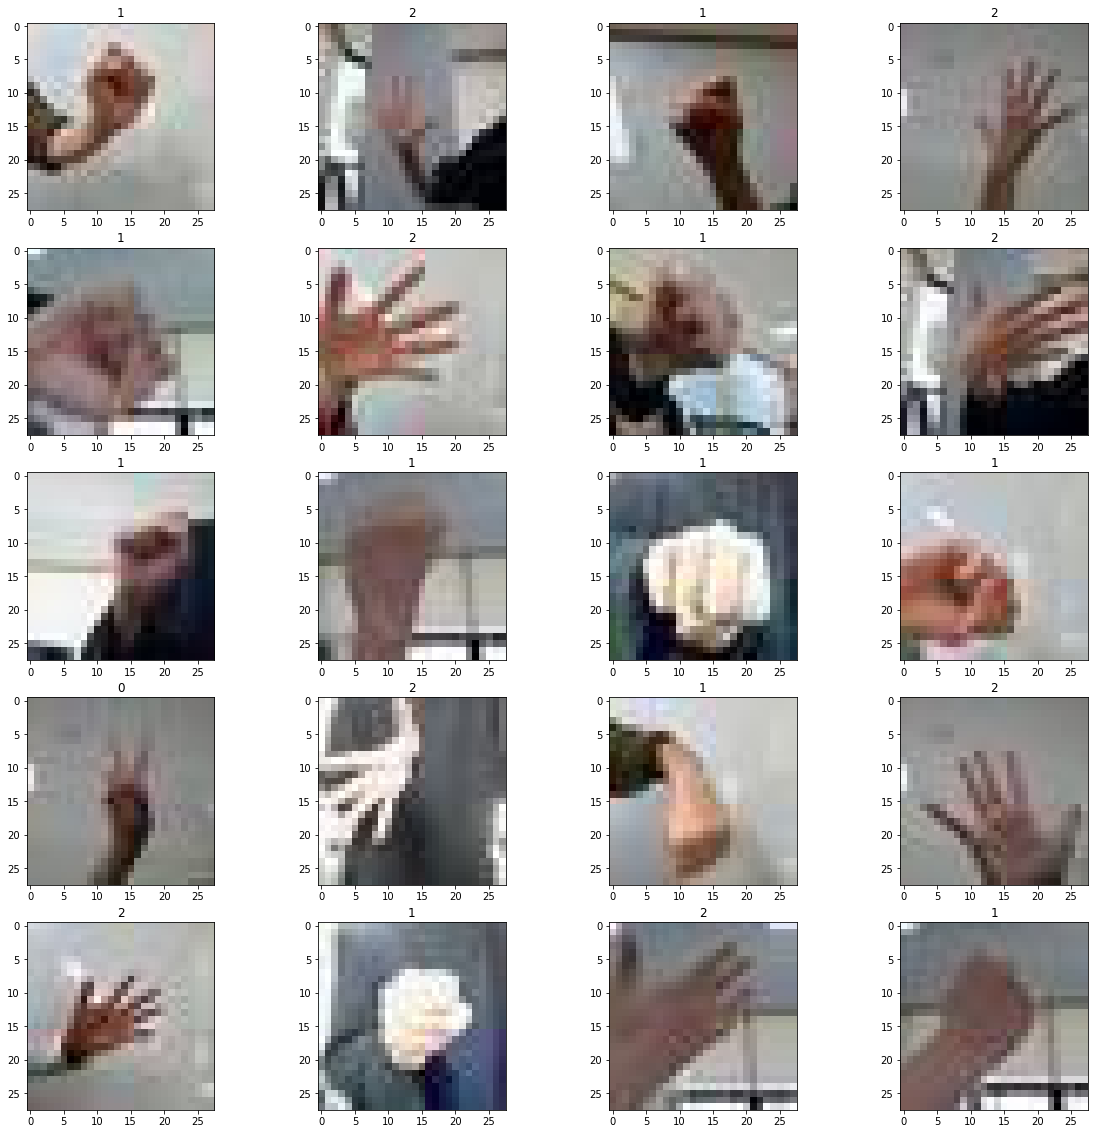

In [85]:
fig = plt.figure(figsize=(20, 20))
for i in range(5): 
    for j in range(4):
        ax = fig.add_subplot(5,4, 4*i+j+1)
        n = random.randint(0, 7000)
        ax.imshow(x_train[n])
        ax.set_title(y_train[n])

## 모델 만들기

In [73]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

def make_model():
    model=keras.models.Sequential()
    model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
    model.add(keras.layers.MaxPool2D(2,2))
    model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dense(3, activation='softmax'))

    return model

## 모델 학습

In [35]:
def train_graph(history, title='title'):
    loss_ax = plt.subplot(211)

    loss_ax.plot(history['loss'], 'y', label='train loss')
    loss_ax.plot(history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='best')
    plt.title(title+' loss')
    plt.show()
    
    acc_ax = plt.subplot(212)
    acc_ax.plot(history['accuracy'], 'b', label='train acc')
    acc_ax.plot(history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='best')
    plt.title(title+' accuracy')    
    plt.show()

### batch size 8, 16, 32, 64, 128 실험

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 3, 3, 64)          18496     
_________________________________________________________________
flatten_21 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 16)              

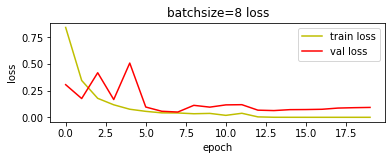

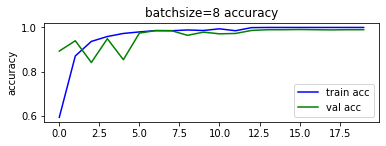

In [57]:
model = make_model()
model.summary()
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
hist = model.fit(x_train_norm, y_train, epochs=20,
          batch_size=8,validation_split=0.15, shuffle=True, verbose=1)
train_graph(hist.history, 'batchsize=8')

Epoch 1/20
418/418 [==============================] - 2s 4ms/step - loss: 0.8282 - accuracy: 0.6251 - val_loss: 0.4962 - val_accuracy: 0.7980
Epoch 2/20
418/418 [==============================] - 1s 4ms/step - loss: 0.4140 - accuracy: 0.8460 - val_loss: 0.2387 - val_accuracy: 0.9058
Epoch 3/20
418/418 [==============================] - 1s 3ms/step - loss: 0.2469 - accuracy: 0.9131 - val_loss: 0.4706 - val_accuracy: 0.8158
Epoch 4/20
418/418 [==============================] - 1s 4ms/step - loss: 0.1714 - accuracy: 0.9410 - val_loss: 0.1775 - val_accuracy: 0.9304
Epoch 5/20
418/418 [==============================] - 1s 4ms/step - loss: 0.1205 - accuracy: 0.9550 - val_loss: 0.0788 - val_accuracy: 0.9711
Epoch 6/20
418/418 [==============================] - 1s 3ms/step - loss: 0.0839 - accuracy: 0.9720 - val_loss: 0.0939 - val_accuracy: 0.9576
Epoch 7/20
418/418 [==============================] - 1s 3ms/step - loss: 0.0701 - accuracy: 0.9739 - val_loss: 0.1079 - val_accuracy: 0.9652
Epoch 

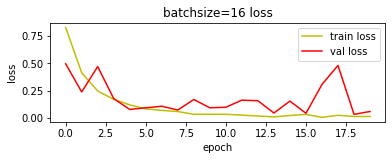

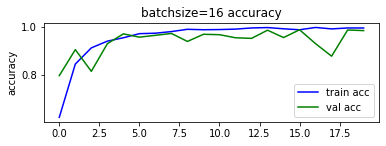

In [58]:
model = make_model()
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
hist = model.fit(x_train_norm, y_train, epochs=20,
          batch_size=16,validation_split=0.15, shuffle=True, verbose=1)
train_graph(hist.history, 'batchsize=16')

Epoch 1/20
209/209 [==============================] - 1s 4ms/step - loss: 0.8974 - accuracy: 0.5775 - val_loss: 0.8180 - val_accuracy: 0.6239
Epoch 2/20
209/209 [==============================] - 1s 4ms/step - loss: 0.4922 - accuracy: 0.8079 - val_loss: 0.4080 - val_accuracy: 0.8302
Epoch 3/20
209/209 [==============================] - 1s 4ms/step - loss: 0.3285 - accuracy: 0.8806 - val_loss: 0.4582 - val_accuracy: 0.8251
Epoch 4/20
209/209 [==============================] - 1s 4ms/step - loss: 0.2413 - accuracy: 0.9149 - val_loss: 0.4474 - val_accuracy: 0.8268
Epoch 5/20
209/209 [==============================] - 1s 4ms/step - loss: 0.1780 - accuracy: 0.9371 - val_loss: 0.2590 - val_accuracy: 0.8930
Epoch 6/20
209/209 [==============================] - 1s 4ms/step - loss: 0.1335 - accuracy: 0.9552 - val_loss: 0.1218 - val_accuracy: 0.9550
Epoch 7/20
209/209 [==============================] - 1s 4ms/step - loss: 0.1059 - accuracy: 0.9642 - val_loss: 0.1181 - val_accuracy: 0.9618
Epoch 

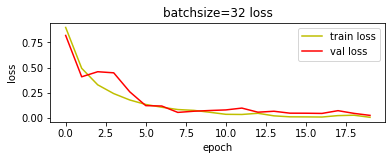

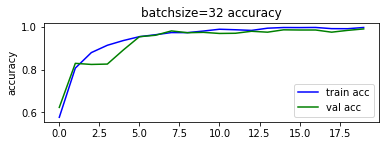

In [59]:
model = make_model()
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
hist = model.fit(x_train_norm, y_train, epochs=20,
          batch_size=32,validation_split=0.15, shuffle=True, verbose=1)
train_graph(hist.history, 'batchsize=32')

Epoch 1/20
105/105 [==============================] - 1s 5ms/step - loss: 1.0344 - accuracy: 0.4528 - val_loss: 0.9374 - val_accuracy: 0.6732
Epoch 2/20
105/105 [==============================] - 0s 4ms/step - loss: 0.7387 - accuracy: 0.7047 - val_loss: 0.8371 - val_accuracy: 0.6409
Epoch 3/20
105/105 [==============================] - 0s 4ms/step - loss: 0.4712 - accuracy: 0.8156 - val_loss: 0.7726 - val_accuracy: 0.6817
Epoch 4/20
105/105 [==============================] - 0s 4ms/step - loss: 0.3360 - accuracy: 0.8741 - val_loss: 0.4089 - val_accuracy: 0.8336
Epoch 5/20
105/105 [==============================] - 0s 4ms/step - loss: 0.2620 - accuracy: 0.9037 - val_loss: 0.2606 - val_accuracy: 0.8990
Epoch 6/20
105/105 [==============================] - 0s 4ms/step - loss: 0.2049 - accuracy: 0.9309 - val_loss: 0.1708 - val_accuracy: 0.9448
Epoch 7/20
105/105 [==============================] - 0s 4ms/step - loss: 0.1744 - accuracy: 0.9399 - val_loss: 0.2090 - val_accuracy: 0.9261
Epoch 

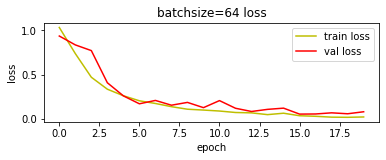

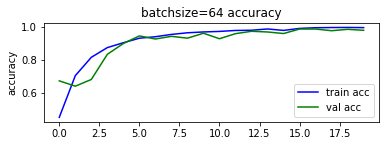

In [60]:
model = make_model()
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
hist = model.fit(x_train_norm, y_train, epochs=20,
          batch_size=64, validation_split=0.15, shuffle=True, verbose=1)
train_graph(hist.history, 'batchsize=64')

Epoch 1/20
53/53 [==============================] - 1s 7ms/step - loss: 1.0385 - accuracy: 0.4657 - val_loss: 1.1634 - val_accuracy: 0.3234
Epoch 2/20
53/53 [==============================] - 0s 5ms/step - loss: 0.7303 - accuracy: 0.7089 - val_loss: 1.3404 - val_accuracy: 0.3820
Epoch 3/20
53/53 [==============================] - 0s 4ms/step - loss: 0.5102 - accuracy: 0.8061 - val_loss: 0.9380 - val_accuracy: 0.5840
Epoch 4/20
53/53 [==============================] - 0s 4ms/step - loss: 0.3849 - accuracy: 0.8614 - val_loss: 0.4655 - val_accuracy: 0.8277
Epoch 5/20
53/53 [==============================] - 0s 4ms/step - loss: 0.3390 - accuracy: 0.8776 - val_loss: 0.2684 - val_accuracy: 0.9168
Epoch 6/20
53/53 [==============================] - 0s 4ms/step - loss: 0.2875 - accuracy: 0.9031 - val_loss: 0.2275 - val_accuracy: 0.9177
Epoch 7/20
53/53 [==============================] - 0s 4ms/step - loss: 0.2566 - accuracy: 0.9132 - val_loss: 0.2454 - val_accuracy: 0.9194
Epoch 8/20
53/53 [==

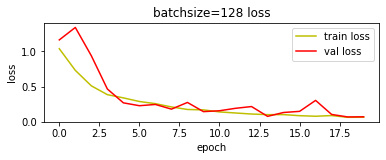

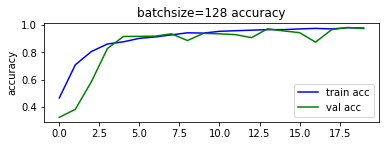

In [61]:
model = make_model()
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
hist = model.fit(x_train_norm, y_train, epochs=20,
          batch_size=128,validation_split=0.15, shuffle=True)
train_graph(hist.history, 'batchsize=128')

### 관찰
batchsize가 8, 16, 128에서는 val loss가 크게 들쑥날쑥한 모습을 보입니다. batchsize 32, 64에서는 val loss가 비교적 안정적이고 epoch 10\~15 사이에 val loss가 최고치에 도달합니다. 따라서 batchsize는 32 또는 64를 쓰고 오버피팅을 막기 위해 epoch 10\~15까지만 트레이닝하는게 적절할 것입니다.

## Test 데이터 만들기

In [62]:
image_dir_path = os.getenv("HOME") + "/aiffel/data_rsp/test/scissor"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/data_rsp/test/rock"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/data_rsp/test/paper"
resize_images(image_dir_path)

214  images to be resized.
214  images resized.
212  images to be resized.
212  images resized.
246  images to be resized.
246  images resized.


In [63]:
image_dir_path = os.getenv("HOME") + "/aiffel/data_rsp/test"
(x_test, y_test)=load_data(image_dir_path, 214+212+246)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_train)의 이미지 개수는 672 입니다.
x_test shape: (672, 28, 28, 3)
y_test shape: (672,)


In [64]:
model.evaluate(x_test_norm, y_test)

21/21 [==============================] - 0s 2ms/step - loss: 2.3234 - accuracy: 0.5908


[2.323408603668213, 0.5907738208770752]

## 모델 빌드 & 학습 & 평가

데이 터를 다양화 했지만 training set에서 99.9%에 달하는 정확도가 val/test 데이터셋에서는 유지되지 않습니다. 이런 오버피팅을 해결하기 위해 배치 정규화를 Conv레이어 뒤에 적용해줍니다.

In [75]:

def make_model():
    model=keras.models.Sequential()
    model.add(keras.layers.Conv2D(16, (3,3), padding='same', input_shape=(28,28,3)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPool2D(2,2))
    
    model.add(keras.layers.Conv2D(32, (3,3)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling2D((2,2)))
    
    model.add(keras.layers.Conv2D(64, (3,3)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dense(3, activation='softmax'))

    return model

Epoch 1/15
209/209 [==============================] - 2s 5ms/step - loss: 0.4088 - accuracy: 0.8394 - val_loss: 3.8764 - val_accuracy: 0.0000e+00
Epoch 2/15
209/209 [==============================] - 1s 4ms/step - loss: 0.1014 - accuracy: 0.9696 - val_loss: 1.1452 - val_accuracy: 0.5951
Epoch 3/15
209/209 [==============================] - 1s 4ms/step - loss: 0.0475 - accuracy: 0.9855 - val_loss: 0.0060 - val_accuracy: 0.9992
Epoch 4/15
209/209 [==============================] - 1s 4ms/step - loss: 0.0231 - accuracy: 0.9945 - val_loss: 0.1027 - val_accuracy: 0.9593
Epoch 5/15
209/209 [==============================] - 1s 4ms/step - loss: 0.0255 - accuracy: 0.9931 - val_loss: 0.0548 - val_accuracy: 0.9779
Epoch 6/15
209/209 [==============================] - 1s 4ms/step - loss: 0.0097 - accuracy: 0.9979 - val_loss: 0.2167 - val_accuracy: 0.9126
Epoch 7/15
209/209 [==============================] - 1s 4ms/step - loss: 0.0032 - accuracy: 0.9999 - val_loss: 0.0065 - val_accuracy: 0.9975
Ep

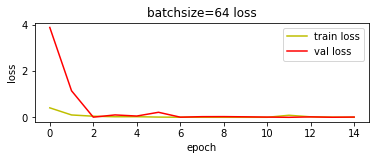

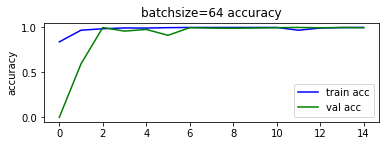





test loss & accuracy: 
21/21 [==============================] - 0s 2ms/step - loss: 3.0960 - accuracy: 0.6205


[3.0960347652435303, 0.6205357313156128]

In [77]:
model = make_model()
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
hist = model.fit(x_train_norm, y_train, epochs=15,
          batch_size=32, validation_split=0.15, shuffle=True, verbose=1)
train_graph(hist.history, 'batchsize=64')
print('\n\n\n')
print('test loss & accuracy: ')
model.evaluate(x_test_norm, y_test)

62% 예측성공률을 달성했습니다🎉

### 못 맞힌 데이터 (테스트셋)

예측확률분포: [2.6935427e-09 3.0256513e-11 1.0000000e+00]
라벨: 0, 예측결과: 2


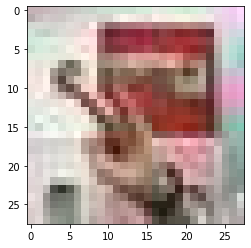

예측확률분포: [6.788429e-09 8.026607e-11 1.000000e+00]
라벨: 0, 예측결과: 2


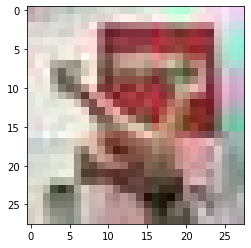

예측확률분포: [1.6797602e-06 4.2949116e-01 5.7050717e-01]
라벨: 1, 예측결과: 2


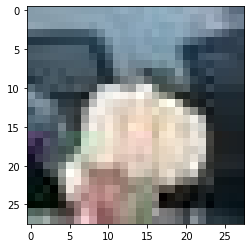

예측확률분포: [0.00100626 0.30303884 0.6959549 ]
라벨: 1, 예측결과: 2


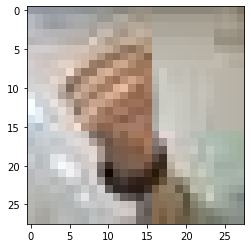

예측확률분포: [9.9972266e-01 2.7364632e-04 3.7221607e-06]
라벨: 2, 예측결과: 0


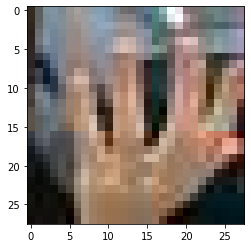

In [87]:
predicted_result = model.predict(x_test_norm)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑아봅시다.
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()

## 회고

웹캠으로 이미지를 찍어 분류기를 만드는게 손쉬운 서비스로 제공되고있는것이 놀라웠습니다.  
  
MNIST, CIFAR-10/100 같이 미리 제공되는 데이터가 아니라 직접 만든 데이터로 모델을 트레이닝하니 살아있는 딥러닝을 하는 느낌이 듭니다. 사진을 어떻게 찍으면 유용하면서도 다양한 데이터셋을 만들수있을까, 이 데이터셋에 맞는 모델은 어떤 구조를 가질까 고민을 하게되어서 좋았습니다.

못맞힌 사진 중에 사람의 눈으로 봤을때는 '이거는 충분히 맞힐만한데 왜 못맞혔을까?' 의문이 드는 사진이 있습니다. 모델이나 트레이닝의 문제인지 해상도의 문제인지 밝혀보고싶습니다.
